## Initial Setup

In [ ]:
%%capture
#%%script false
!pip install shap==0.23.0
!pip install xgboost==0.82
!pip install catboost
!pip install lightgbm==2.2.4
#!pip install tensorboardcolab
!pip install seaborn==0.9.0
!pip install pandas==0.24.2
!pip install numpy==1.16.2
!pip install scikit-optimize==0.6

!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

#Restart Runtime

## Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('figure', figsize=(20.0, 6.0))

import shap
from tqdm import tqdm_notebook as tqdm

#from sklearn.externals import joblib #Use joblib module instead
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit #, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

import sklearn.svm as svm
import sklearn.neighbors as knn


from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, f1_score
from sklearn.metrics import mean_squared_error #, mean_squared_log_error

In [ ]:
# Change id only
train_data_og = pd.read_csv("https://drive.google.com/uc?export=download&id=1po6Nsa8NcpQo2Wtn5sqrqi_H4SiR7uXl")
sub_data_og = pd.read_csv("https://drive.google.com/uc?export=download&id=1JW24OVMPWpP1gcIj724amcMXIWxWTEpA")

### Manipulation

Mean Encoding.  
Divide and Multiply columns.  


Time Series  
Date parts  
Lag values  
Difference between dates 

In [ ]:
def clean_data(dataset) :
    
    dataset = dataset.drop(["Unique_ID", "MORTGAGE NUMBER", "FSA"], axis = 1)
    dataset.columns = dataset.columns.str.replace(" ", "_")
    
    #log transformation
#     dataset["PROPERTY_VALUE"] = np.log(dataset["PROPERTY_VALUE"])
#     dataset["MORTGAGE_PAYMENT"] = np.log(dataset["MORTGAGE_PAYMENT"])
#     dataset["MORTGAGE_AMOUNT"] = np.log(dataset["MORTGAGE_AMOUNT"])
#     dataset["INCOME"] = np.log(dataset["INCOME"])
    
    
    
    return dataset

train_data = clean_data(train_data_og)
sub_data = clean_data(sub_data_og)

sub_data = sub_data.drop(["RESULT"], axis = 1)

In [ ]:
#chrome-extension://gbkeegbaiigmenfmjfclcdgdpimamgkj/views/app.html - Data Dichtinoary
train_data.head()

,PROPERTY_VALUE,MORTGAGE_PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE_AMOUNT,RATE,MORTGAGE_PURPOSE,PAYMENT_FREQUENCY,PROPERTY_TYPE,TERM,AGE_RANGE,GENDER,INCOME,INCOME_TYPE,NAICS_CODE,CREDIT_SCORE,RESULT
0,900000,5429,61.98,65.00,71.63,360,1040000.0,4.0,Refinance,Monthly,Single Detached,12,Under 25,Male,108000,8,44-45,681,FUNDED
1,386000,2179,35.22,74.29,40.65,360,390000.0,4.5,Refinance,Monthly,Single Detached,12,70 and over,Male,78000,2,56,710,FUNDED
2,531000,2152,30.97,80.00,35.41,360,424800.0,3.5,Purchase,Monthly,Single Detached,6,35-39,Female,87000,2,72,709,FUNDED
3,1200000,5410,19.04,75.00,34.14,360,960000.0,5.5,Purchase,Monthly,Single Detached,12,45-49,Male,300000,8,54,761,FUNDED
4,350000,3342,29.59,80.00,34.85,360,592000.0,5.0,Refinance,Monthly,Single Detached,12,50-54,Male,147000,8,62,762,FUNDED


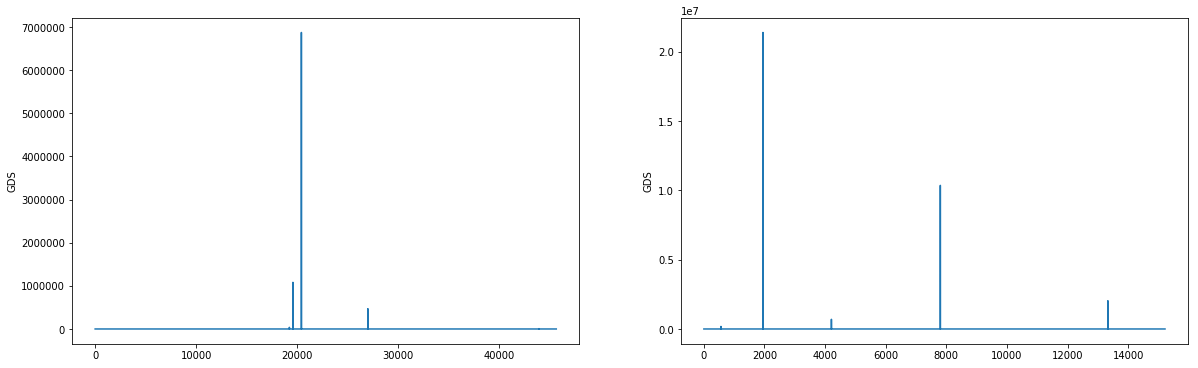

In [ ]:
plt.subplot(1,2,1)
sns.lineplot(range(len(train_data)), train_data.GDS)
plt.subplot(1,2,2)
sns.lineplot(range(len(sub_data)), sub_data.GDS)
plt.show()

In [ ]:
train_data[train_data.GDS > 1000]

,PROPERTY_VALUE,MORTGAGE_PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE_AMOUNT,RATE,MORTGAGE_PURPOSE,PAYMENT_FREQUENCY,PROPERTY_TYPE,TERM,AGE_RANGE,GENDER,INCOME,INCOME_TYPE,NAICS_CODE,CREDIT_SCORE,RESULT
10011,1250000,3368,3492.69,65.00,5298.22,360,812500.00,4.00,Purchase,Monthly,Single Detached,12,65-69,Male,1000,8,56,677,FUNDED
14010,270000,1025,1124.64,55.56,1220.64,360,150000.00,5.00,Purchase,Monthly,Townhouse Freehold,12,50-54,Unknown,1000,7,81,769,FUNDED
15339,379000,729,1100.75,30.45,1112.75,360,106469.70,5.00,Purchase,Monthly,High Rise,12,55-59,Unknown,1000,2,62,679,FUNDED
19223,1015000,3739,38390.90,64.83,38390.90,360,658000.00,4.75,Purchase,Monthly,Single Detached,12,30-34,Unknown,12000,5,72,0,FUNDED
19575,353000,2156,1080756.30,56.20,1080756.30,360,370000.00,5.00,Refinance,Monthly,Townhouse Freehold,12,35-39,Unknown,30000,8,42,653,FUNDED
20414,1795000,5347,6872300.00,45.42,13462562.50,360,815399.64,5.00,Purchase,Monthly,Single Detached,12,55-59,Female,6000,6,81,690,FUNDED
26990,377000,1755,470658.22,64.31,2461054.38,360,290992.50,6.00,Purchase,Monthly,High Rise,12,45-49,Female,139000,8,56,772,FUNDED
27870,2285000,6143,1161.02,59.74,1253.28,300,700000.00,8.00,Refinance,Monthly,Single Detached,12,70 and over,Male,13000,6,81,706,FUNDED
37150,396000,1740,1100.06,65.00,1269.77,360,300000.00,5.50,Refinance,Monthly,Townhouse Freehold,12,55-59,Male,3000,6,81,468,FUNDED
43915,3500000,15328,7739.08,60.00,7811.58,300,1800000.00,5.50,Refinance,Monthly,Single Detached,12,45-49,Female,2000,8,56,646,FUNDED


In [ ]:
sub_data[sub_data.GDS > 1000]

## EDA

### Distribution

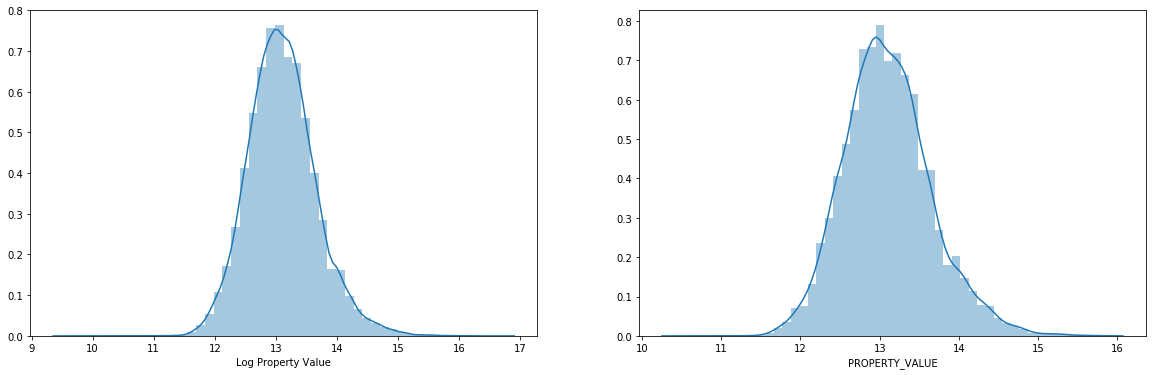

In [ ]:
plt.subplot(1,2,1)
sns.distplot(np.log(train_data["PROPERTY_VALUE"]), axlabel = "Log Property Value")
plt.subplot(1,2,2)
sns.distplot(np.log(sub_data["PROPERTY_VALUE"]))
plt.show()

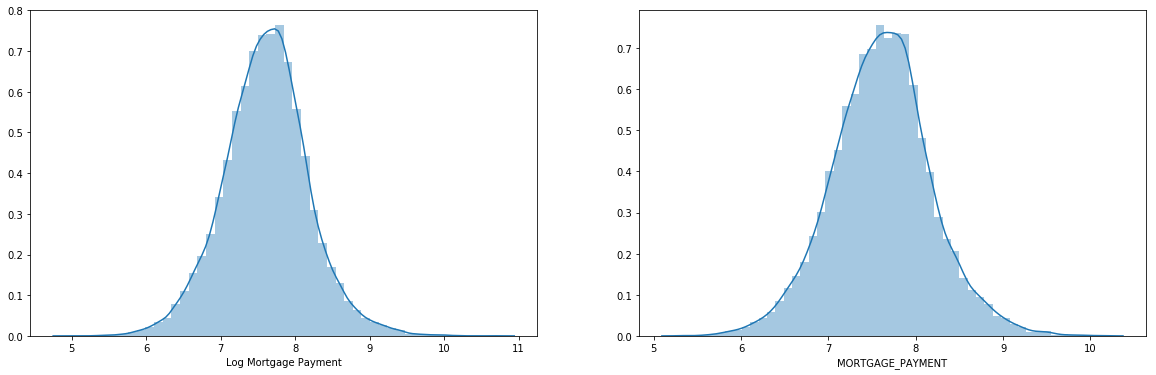

In [ ]:
plt.subplot(1,2,1)
sns.distplot(np.log(train_data["MORTGAGE_PAYMENT"]), axlabel = "Log Mortgage Payment")
plt.subplot(1,2,2)
sns.distplot(np.log(sub_data["MORTGAGE_PAYMENT"]))
plt.show()

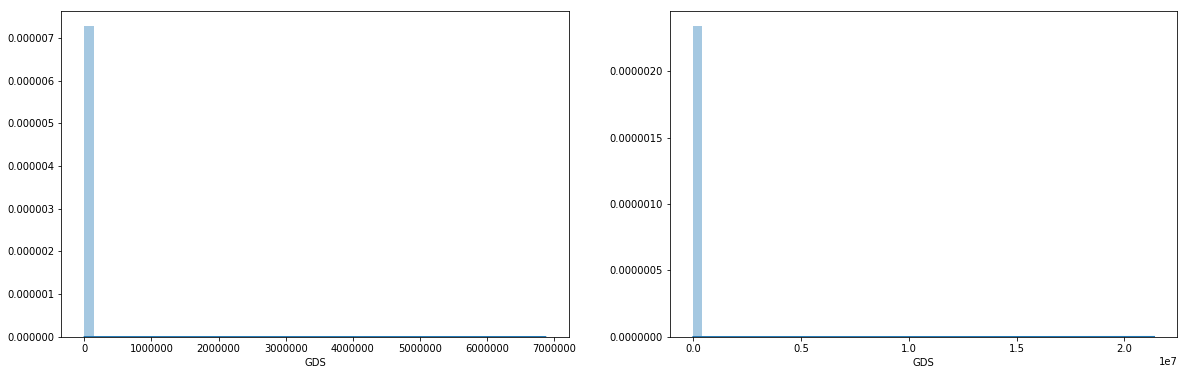

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data["GDS"])
plt.subplot(1,2,2)
sns.distplot(sub_data["GDS"])
plt.show()

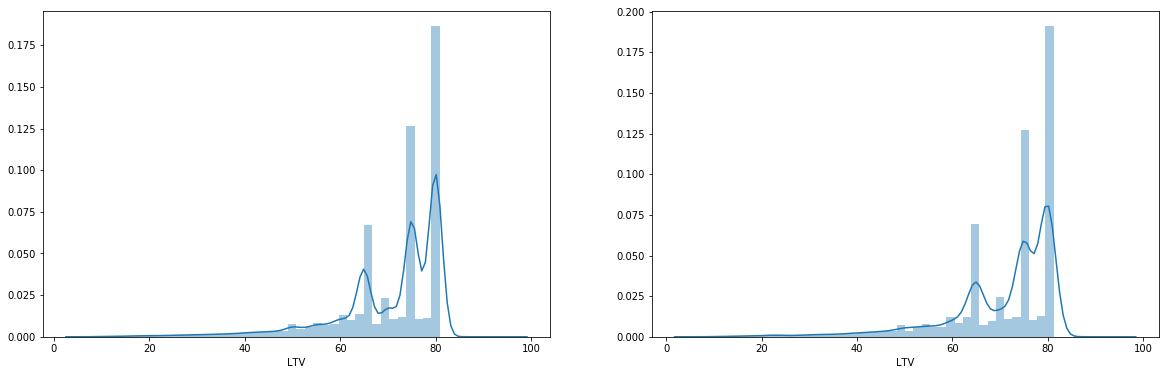

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data["LTV"])
plt.subplot(1,2,2)
sns.distplot(sub_data["LTV"])
plt.show()

#CALCULATE Appraised Property Value = Mortage_amount * LTV

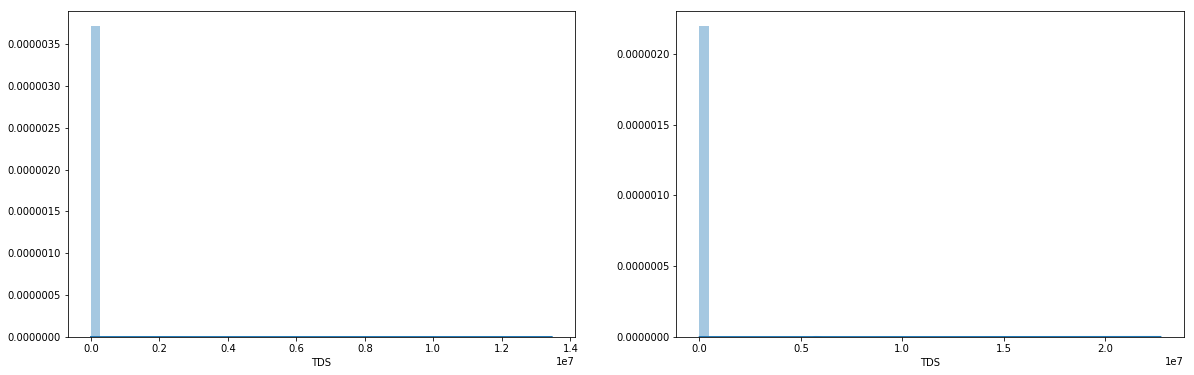

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data["TDS"])
plt.subplot(1,2,2)
sns.distplot(sub_data["TDS"])
plt.show()

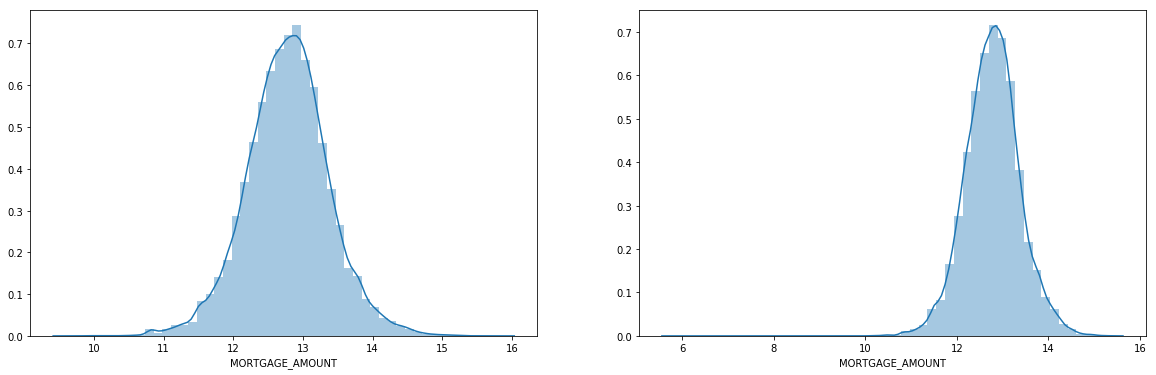

In [ ]:
### THERE SEEMS TO ONE SMALL OUTLIER!
plt.subplot(1,2,1)
sns.distplot(np.log(train_data["MORTGAGE_AMOUNT"]))
plt.subplot(1,2,2)
sns.distplot(np.log(sub_data["MORTGAGE_AMOUNT"]))
plt.show()

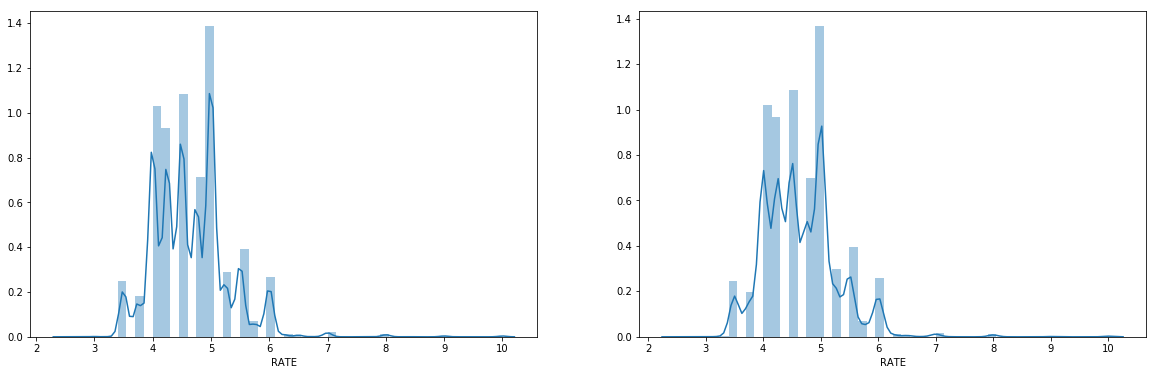

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data["RATE"])
plt.subplot(1,2,2)
sns.distplot(sub_data["RATE"])
plt.show()

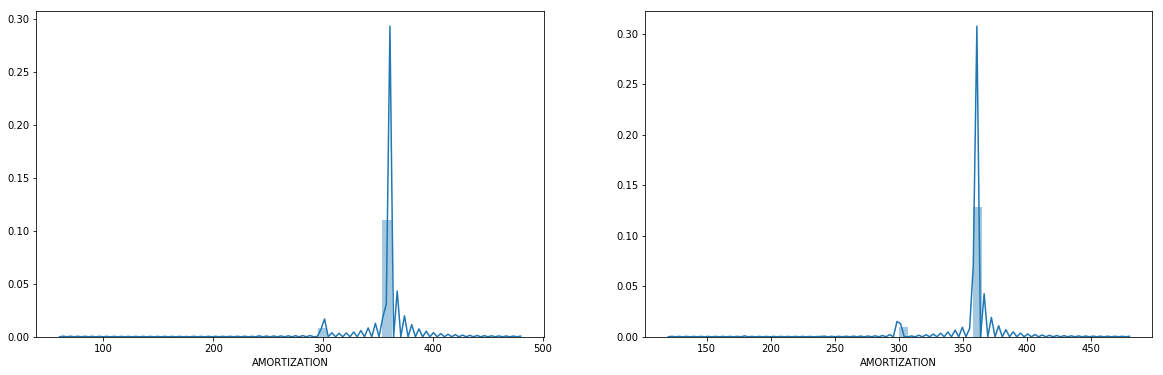

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data["AMORTIZATION"])
plt.subplot(1,2,2)
sns.distplot(sub_data["AMORTIZATION"])
plt.show()

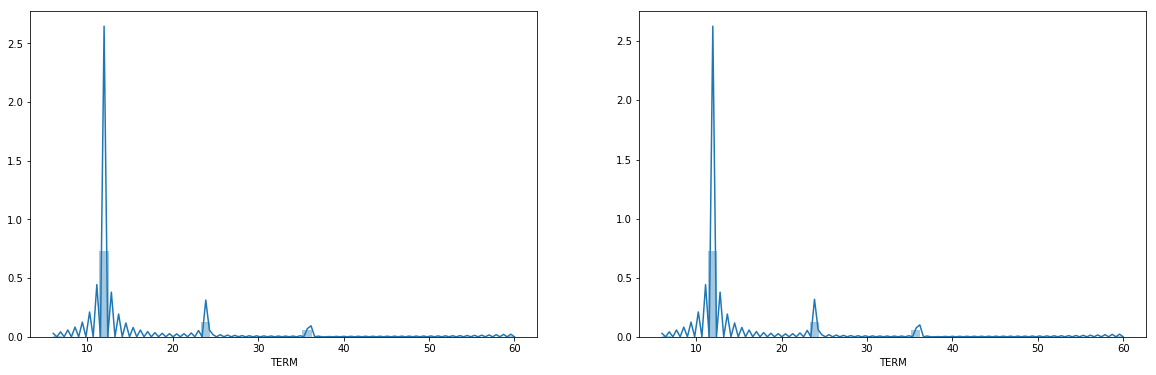

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data["TERM"])
plt.subplot(1,2,2)
sns.distplot(sub_data["TERM"])
plt.show()

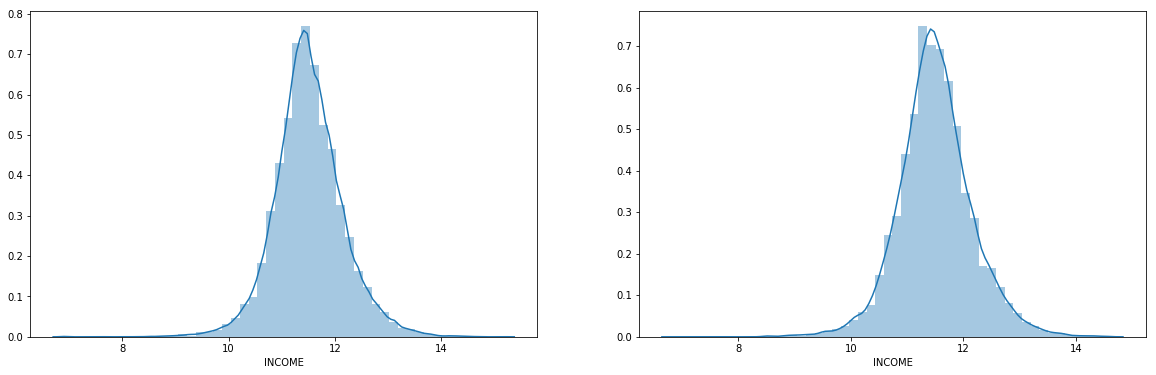

In [ ]:
#ARE THERE SOME SMALL OUTLIERS?
plt.subplot(1,2,1)
sns.distplot(np.log(train_data["INCOME"]))
plt.subplot(1,2,2)
sns.distplot(np.log(sub_data["INCOME"]))
plt.show()

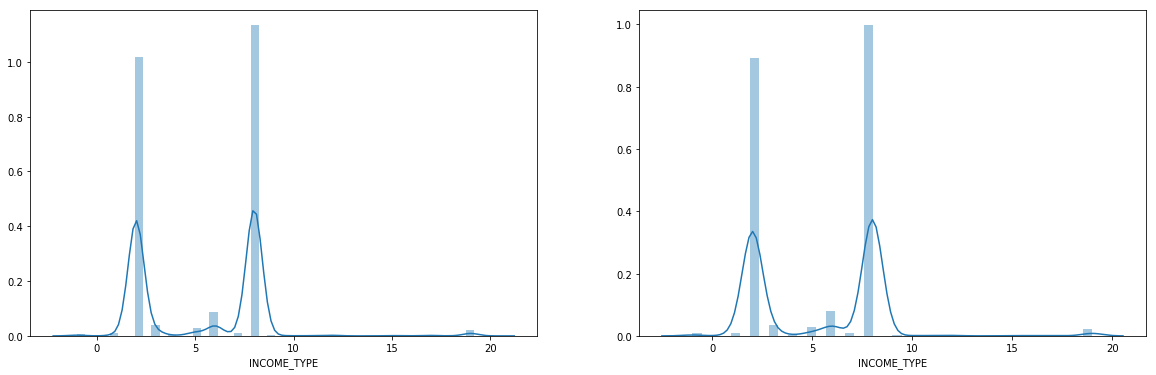

In [ ]:
#ARE THERE SOME SMALL OUTLIERS?
plt.subplot(1,2,1)
sns.distplot(train_data["INCOME_TYPE"])
plt.subplot(1,2,2)
sns.distplot(sub_data["INCOME_TYPE"])
plt.show()

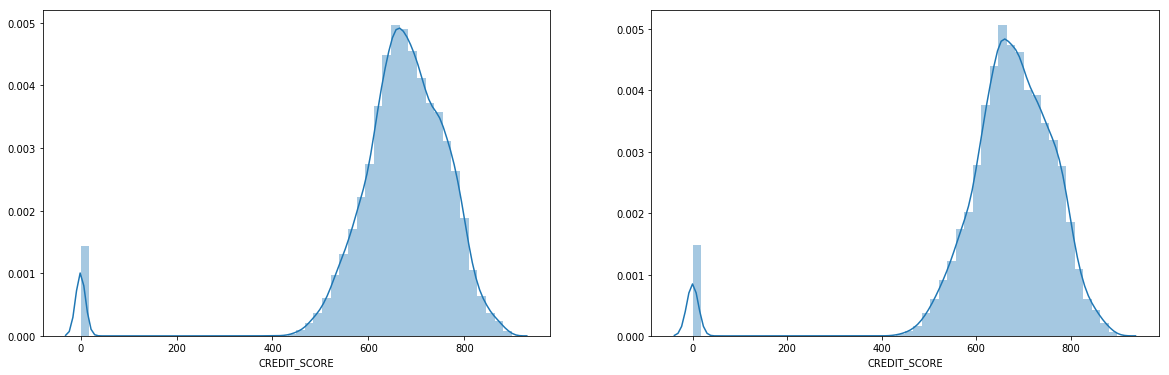

In [ ]:
#ARE THERE SOME SMALL OUTLIERS?
plt.subplot(1,2,1)
sns.distplot(train_data["CREDIT_SCORE"])
plt.subplot(1,2,2)
sns.distplot(sub_data["CREDIT_SCORE"])
plt.show()

### Univariate

Distributions, Outliers

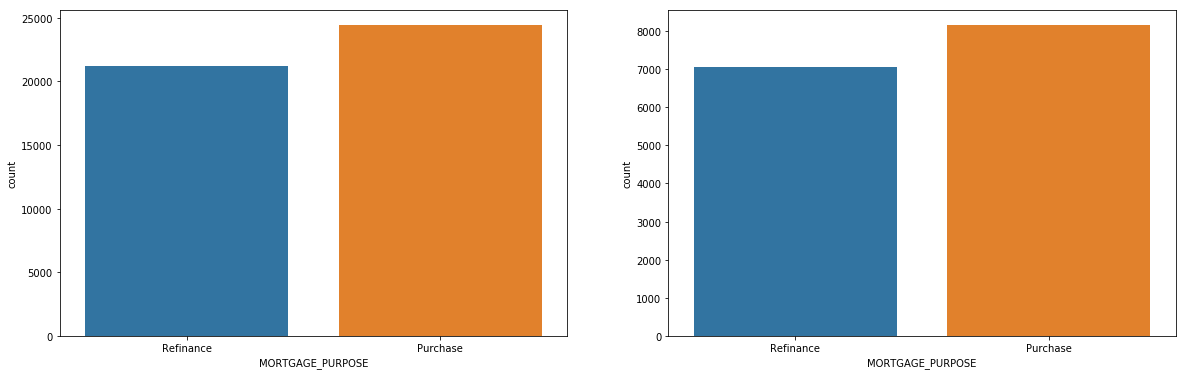

In [ ]:
# USE CROSS TAB and Stacked bar
plt.subplot(1,2,1)
sns.countplot(train_data["MORTGAGE_PURPOSE"])
plt.subplot(1,2,2)
sns.countplot(sub_data["MORTGAGE_PURPOSE"])
plt.show()

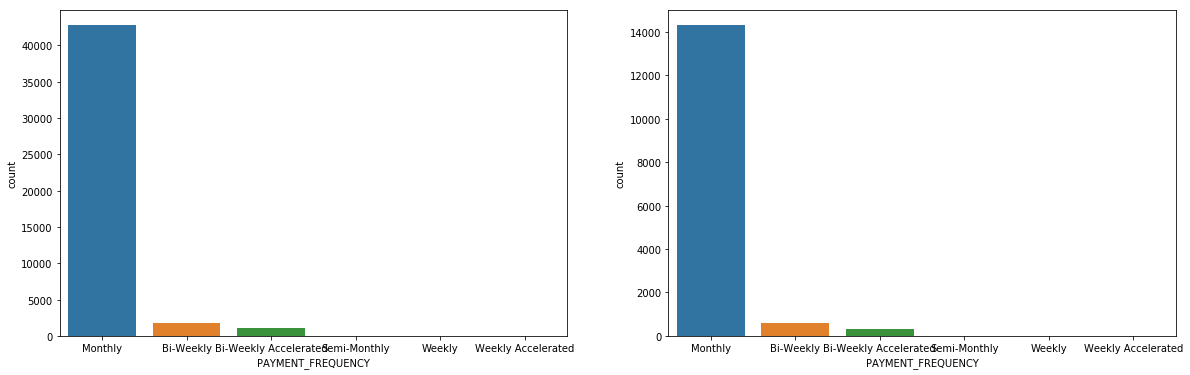

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data["PAYMENT_FREQUENCY"], order = train_data["PAYMENT_FREQUENCY"].value_counts().index)
plt.subplot(1,2,2)
sns.countplot(sub_data["PAYMENT_FREQUENCY"], order = train_data["PAYMENT_FREQUENCY"].value_counts().index)
plt.show()

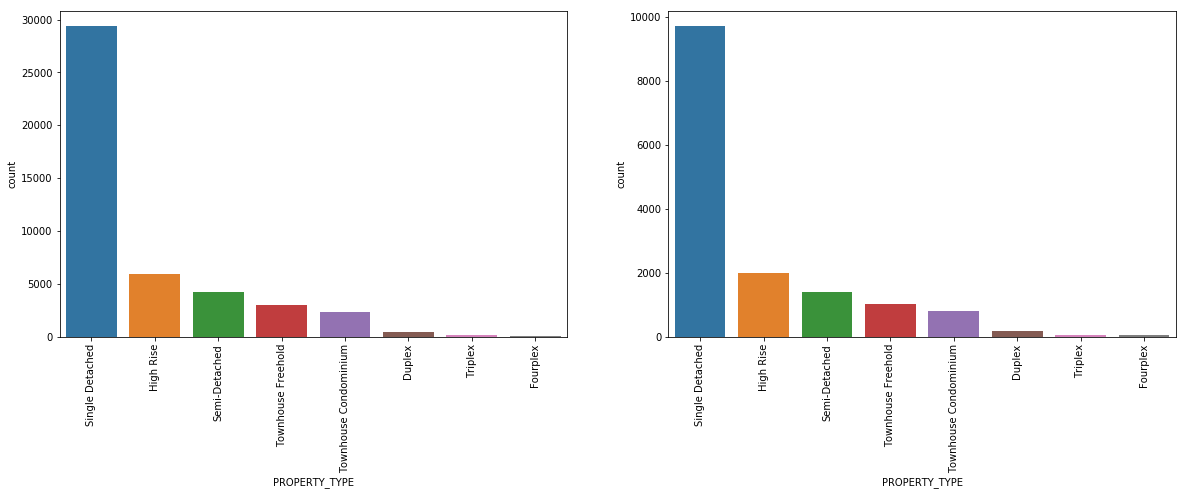

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data["PROPERTY_TYPE"], order = train_data["PROPERTY_TYPE"].value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
sns.countplot(sub_data["PROPERTY_TYPE"], order = train_data["PROPERTY_TYPE"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

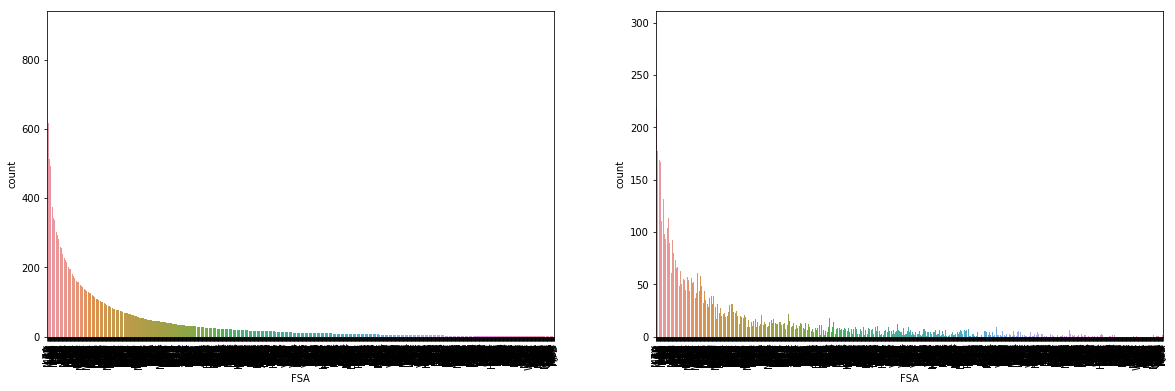

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data["FSA"], order = train_data["FSA"].value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
sns.countplot(sub_data["FSA"], order = train_data["FSA"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

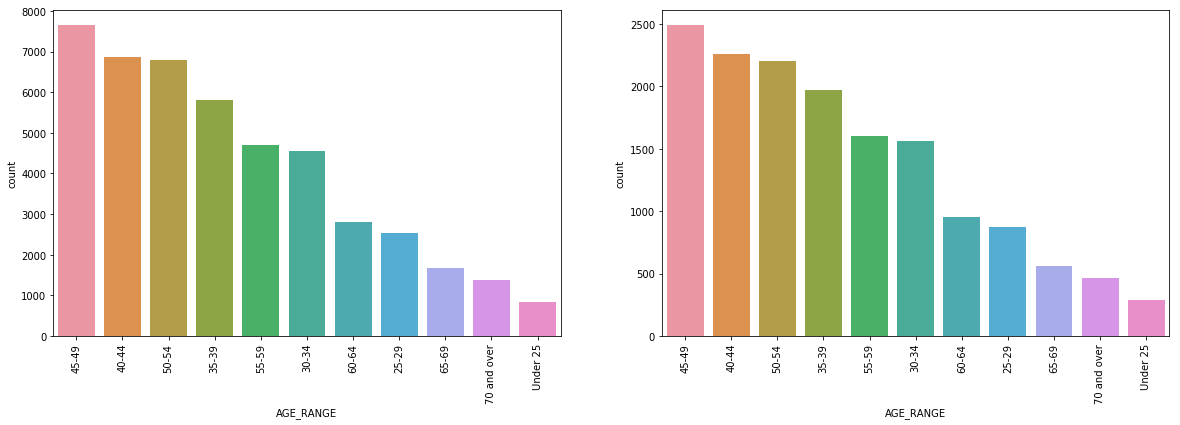

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data["AGE_RANGE"], order = train_data["AGE_RANGE"].value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
sns.countplot(sub_data["AGE_RANGE"], order = train_data["AGE_RANGE"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

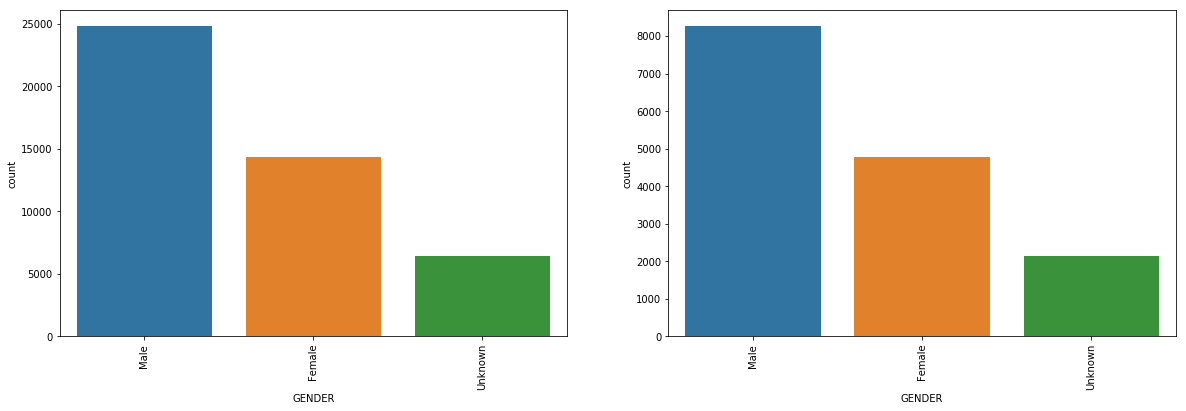

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data["GENDER"], order = train_data["GENDER"].value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
sns.countplot(sub_data["GENDER"], order = train_data["GENDER"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

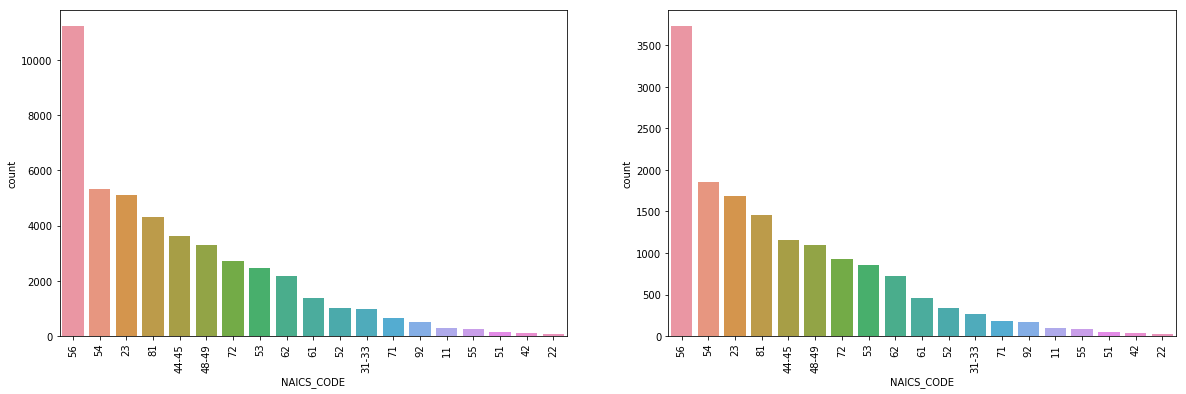

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data["NAICS_CODE"], order = train_data["NAICS_CODE"].value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
sns.countplot(sub_data["NAICS_CODE"], order = train_data["NAICS_CODE"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

FUNDED        78.925113
NOT FUNDED    21.074887
Name: RESULT, dtype: float64


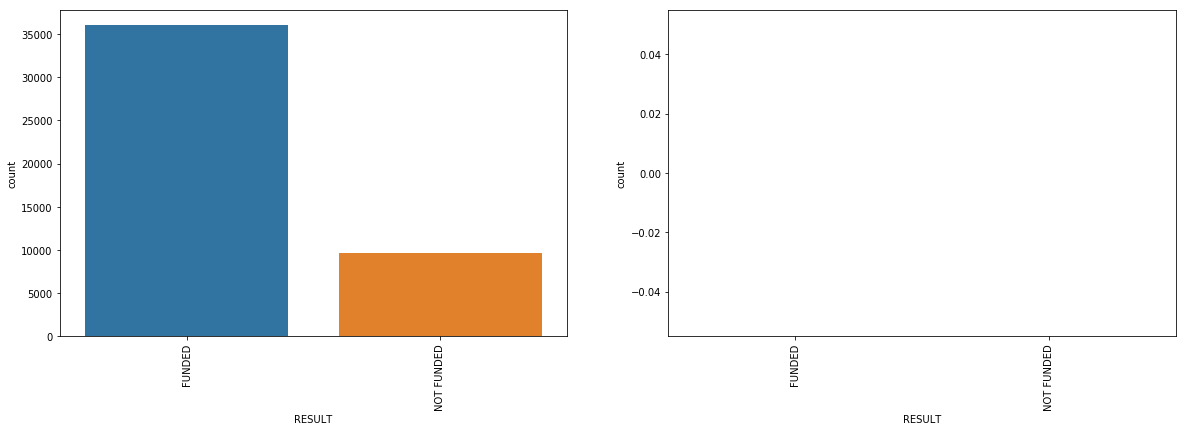

In [ ]:
print(train_data["RESULT"].value_counts() / len(train_data) * 100)

plt.subplot(1,2,1)
sns.countplot(train_data["RESULT"], order = train_data["RESULT"].value_counts().index)
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
sns.countplot(sub_data["RESULT"], order = train_data["RESULT"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

### Bivariate

Comparision, corelation

### With sub_data

Submit pattern, cv on, splitted on

## Data Validation

Replace xxx with proper data  
Ensure testset match submssion set

1) Random split
2) Catogorical split
3) Time based split

In [ ]:
X = train_data.drop(['RESULT'], axis = 1)
#y = train_data["RESULT"]
y = np.where(train_data["RESULT"] == "FUNDED", 1, 0)

cat_train, cat_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75, stratify = train_data["RESULT"], random_state = 42)

X = pd.get_dummies(X) #, dummy_na = True
X_sub = pd.get_dummies(sub_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75, stratify = train_data["RESULT"], random_state = 42)

In [ ]:
print("Train set rows %s, cols %s and y is %s" % (X_train.shape[0], X_train.shape[1], y_train.shape[0]))
print("Cat Train set rows %s, cols %s and y is %s" % (cat_train.shape[0], cat_train.shape[1], y_train.shape[0]))
print("Test set rows %s, cols %s and y is %s" % (X_test.shape[0], X_test.shape[1], y_test.shape[0]))
print("Submission set rows %s, cols %s and y is to be predicted" % (X_sub.shape[0], X_sub.shape[1]))

Train set rows 34231, cols 61 and y is 34231
Cat Train set rows 34231, cols 18 and y is 34231
Test set rows 11411, cols 61 and y is 11411
Submission set rows 15214, cols 61 and y is to be predicted


### Validataion EDA

## Modeling

For Regression verify distribution.  
For Classification verify confusion matrix.  
Use 10 fold cross validation to verify final model.  

### Submission Part

In [ ]:
#np.where(xgb_model.predict(X_sub) == 1, "FUNDED", "NOT FUNDED")

# 0.53035

pd.DataFrame( {'Unique_ID':sub_data_og.Unique_ID, 
               'Result_Predicted' : np.where(xgb_model.predict(X_sub) == 1, "FUNDED", "NOT FUNDED") }).to_csv("CAX.csv", index = False)

In [ ]:
# 0.48557

pd.DataFrame( {'Unique_ID':sub_data_og.Unique_ID, 
               'Result_Predicted' : np.where(cat_model.predict(sub_data) == 1, "FUNDED", "NOT FUNDED") }).to_csv("CAXcat.csv", index = False)

### XGBoost

Monitor metric performance on both train and test.  
No need to addional use metric score. 

In [ ]:
weight

0.21074464666530335

In [ ]:
weight = 1 - (np.sum(y_train) / len(y_train))

In [ ]:

xgb_model = xgb.XGBClassifier(learning_rate=0.1, n_estimators = 100000, objective = 'binary:logistic', scale_pos_weight=weight)
xgb_model.fit(X_train, y_train, eval_metric = "auc", eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 1000, early_stopping_rounds=100)

#joblib.dump(xgb_model, "drive/My Drive/PyColab Work/xxx/xgb_model.sav")
confusion_matrix(y_train, xgb_model.predict(X_train))

In [ ]:
cross_val_score(xgb_model, X_train, y_train, scoring = "roc_auc", cv = 2, n_jobs = 4,verbose = 1)

In [ ]:
from sklearn.model_selection import cross_validate

cross_validate(xgb_model, X_train, y_train, scoring = "roc_auc", cv = 4, n_jobs = 4, verbose = 1)

In [ ]:
plt.figure(figsize = (20, 5))
sns.barplot("feature", "imp", data = pd.DataFrame( {'feature' : X_train.columns, 'imp' : xgb_model.feature_importances_ }).sort_values("imp", ascending = False) )
plt.xticks(rotation = 90)
plt.show()

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(xgb_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

In [ ]:
shap_values = explainer.shap_values(X_test.iloc[0:nsize,:])
b = shap.summary_plot(shap_values, X_test.iloc[0:nsize,:])

#### Hyperparamter Tuning

In [ ]:
cv= RepeatedKFold(2, 2)
xgb_engine = xgb.XGBRegressor() #n_estimator not used
xgb_params = {'booster' : ['gbtree'],
              'max_depth' : [3, 4], 
              'gamma' : [0], 
              'learning_rate' : [0.3], 
              "n_estimators" : [100000], 
              'min_child_weight' : [5, 10], 
              'subsample' : [1], 
              'colsample_bytree' : [0.7, 1], 
              'colsample_bylevel' : [1], 
              'colsample_bynode' : [1], 
              'reg_lambda' : [0], 
              'reg_alpha' : [0]}

xgb_grid = GridSearchCV(xgb_engine, xgb_params, cv = cv, n_jobs = 4, verbose = 0, return_train_score  = True)
xgb_grid.fit(X_train, y_train, eval_set = [(X_train, y_train)], early_stopping_rounds=10, verbose = 1000)

#joblib.dump(xgb_grid, "F:/Vasim/Python Stuff/Flight/gridxgboost.sav")

#print( np.sqrt( -cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv = cv, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, xgb_grid.predict(X_test)) ) )

#### Skopt

In [ ]:
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

# set up hyperparameter space
space = [Integer(3, 50, name='max_depth'),
         Integer(8, 200, name='n_estimators'),
         Integer(3, 50, name='min_child_weight'),
         Real(0.001, 1.0, name='learning_rate')]

import lightgbm
regressor = xgb.XGBRegressor()

from sklearn.model_selection import cross_val_score

@use_named_args(space)
def objective(**params):
    regressor.set_params(**params)
    return -np.mean(cross_val_score(regressor, X_train, y_train, cv=5, n_jobs=1, scoring='neg_mean_squared_error'))

In [ ]:
reg_gp = gp_minimize(objective, space, verbose=False)

print('best score: {}'.format(reg_gp.fun))

print('best params:')
print('        max_depth: {}'.format(reg_gp.x[0]))
print('     n_estimators: {}'.format(reg_gp.x[1]))
print(' min_child_weight: {}'.format(reg_gp.x[2]))
print('    learning_rate: {}'.format(reg_gp.x[3]))

In [ ]:
import skopt.plots
skopt.plots.plot_convergence(reg_gp)

In [ ]:
skopt.plots.plot_evaluations(reg_gp, bins = 20)
plt.show()

In [ ]:
skopt.plots.plot_objective(reg_gp)
plt.show()

#### Hyperopt

### LightGBM
Inbuilt Categorical features

In [ ]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

evals_result = {}

In [ ]:
lgbm_model = lgb.LGBMClassifier(learning_rate=0.01, n_estimators=100000)
lgbm_model.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose = 1000, feval=lgb_f1_score, evals_result=evals_result)

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(lgbm_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

#### Hyperparamter Tuning

In [ ]:
lgbm_engine = lgb.LGBMRegressor()
lgbm_params = {'max_depth' : [17], 'learning_rate' : [0.05], 'n_estimators': [100000],  'min_child_samples' : [3], 'num_leaves' : [40], 'min_child_weight' : [0.001], 
               'min_split_gain' : [0], 'colsample_bytree' : [0.3], 'reg_alpha' : [0], 'reg_lamba' : [0], 'importance_type' : ['split'] }

lgbm_grid = GridSearchCV(lgbm_engine, lgbm_params, cv = 4, n_jobs = 4, verbose = 0)
lgbm_grid.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose = 1000)
#print( np.sqrt( -cross_val_score(lgbm_grid.best_estimator_, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, lgbm_grid.predict(X_test)) ) )

### CAT-Boost

Inbuilt Categorical features

In [ ]:
from catboost import CatBoostClassifier, Pool, cv
categorical_features_indices = np.where(cat_train.dtypes == 'object')[0]

In [ ]:
#from catboost import CatBoostClassifier, Pool
#categorical_features_indices = np.where(cat_train.dtypes == 'object')[0]

cat_model = CatBoostClassifier(loss_function = 'Logloss', eval_metric="F1", scale_pos_weight = weight, depth = 10, iterations=4)
cat_model.fit(cat_train, y_train, eval_set = (cat_test, y_test), 
              cat_features = categorical_features_indices, plot = True, verbose = 1)

#print( np.sqrt( -cross_val_score(cat_model, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error", verbose = False) ) )
#np.sqrt(mean_squared_error(y_test, cat_model.predict(X_test)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.5
0:	learn: 0.4992438	test: 0.5015156	best: 0.5015156 (0)	total: 64.7ms	remaining: 194ms
1:	learn: 0.5047712	test: 0.5041770	best: 0.5041770 (1)	total: 151ms	remaining: 151ms
2:	learn: 0.5208063	test: 0.5153610	best: 0.5153610 (2)	total: 230ms	remaining: 76.5ms
3:	learn: 0.5136305	test: 0.5075472	best: 0.5153610 (2)	total: 252ms	remaining: 0us

bestTest = 0.5153610419
bestIteration = 2

Shrink model to first 3 iterations.


In [ ]:
 f1_score(y_test, cat_model.predict(cat_test))

0.587938580224019

In [ ]:
np.array([["TN", "FP"],["FN", "TP"]])

In [ ]:
confusion_matrix(y_train, cat_model.predict(cat_train))

array([[ 5772,  1442],
       [15060, 11957]])

In [ ]:
 f1_score(y_train, cat_model.predict(cat_train))

0.5916963578780681

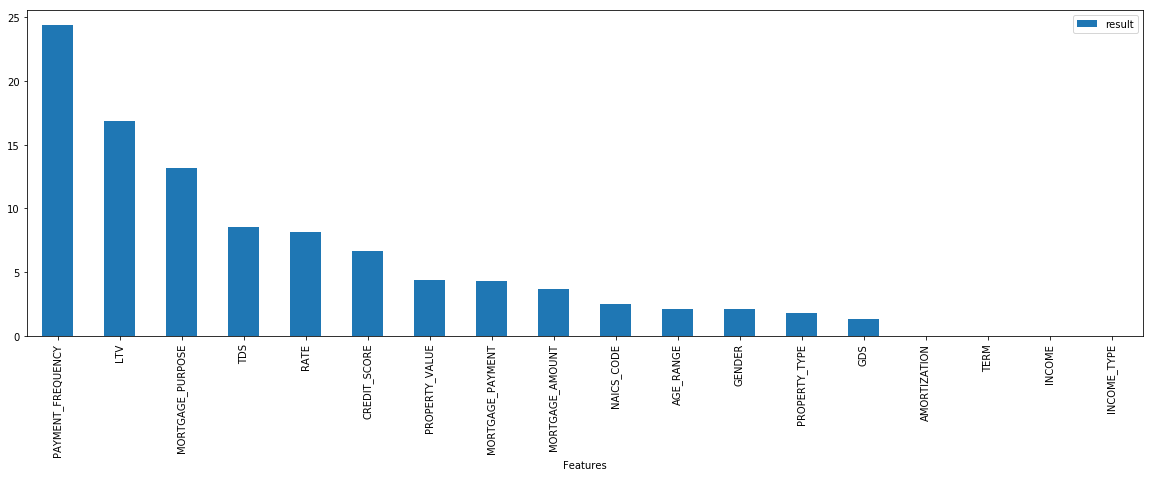

In [ ]:
cv_dataset = Pool(cat_train, y_train, cat_features = categorical_features_indices)
pd.DataFrame( { "Features" :cat_train.columns, "result" : cat_model.get_feature_importance(cv_dataset)} ).sort_values("result", ascending = False).plot.bar("Features", "result")

In [ ]:
#Useful only for iterations tuning.
cat_cv_model = CatBoostClassifier(loss_function = 'Logloss', eval_metric="F1", scale_pos_weight = weight, task_type='GPU')
cv_dataset = Pool(cat_train, y_train, cat_features = categorical_features_indices)

cat_cv = cat.cv(cv_dataset, params=cat_cv_model.get_params(), fold_count = 10, plot = True, verbose = False, iterations = 1000, early_stopping_rounds=50)
cat_cv.shape

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

(54, 9)

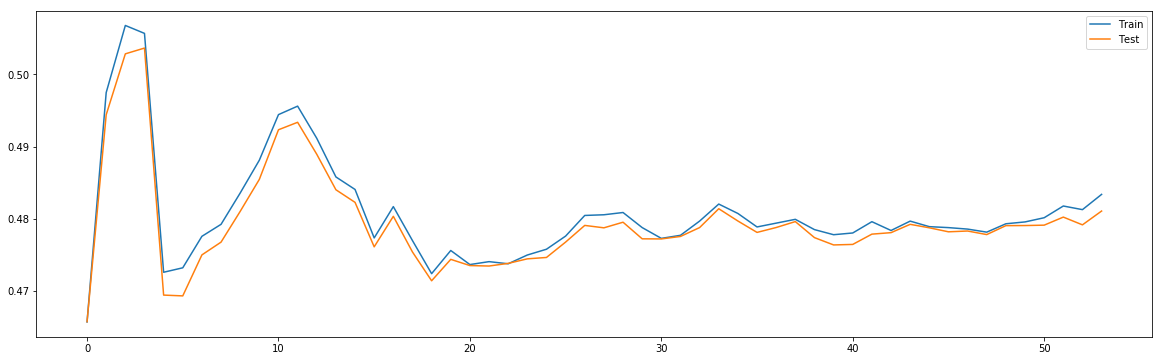

In [ ]:
plt.plot(cat_cv["iterations"], cat_cv["train-F1-mean"], label = "Train")
plt.plot(cat_cv["iterations"], cat_cv["test-F1-mean"], label = "Test")
plt.legend(loc='upper right')
plt.show()

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(cat_model)

nsize = 1000

shap_values = explainer.shap_values(Pool(cat_train.iloc[0:nsize,:], y_train[0:nsize], cat_features=categorical_features_indices))
shap.summary_plot(shap_values, cat_train.iloc[0:nsize,:])

plt.show()

#### Hyperparamter Tuning

In [ ]:
cat_engine = CatBoostClassifier(loss_function = 'Logloss', eval_metric="F1")

cat_params = {'max_depth' : [4], 'learning_rate' : [0.1], 'iterations': [100000], 'colsample_bylevel' : [1]}
    
cat_grid = GridSearchCV(cat_engine, cat_params, cv = 4, n_jobs = 4, verbose = False)

cat_grid.fit(cat_train, y_train, eval_set = (cat_test, y_test), 
             cat_features = categorical_features_indices, plot = True, verbose = 1000, early_stopping_rounds=100)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8822166	test: 0.8822060	best: 0.8822060 (0)	total: 144ms	remaining: 3h 59m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8843825368
bestIteration = 79

Shrink model to first 80 iterations.


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x7fdb085f1dd8>,
             iid='warn', n_jobs=4,
             param_grid={'colsample_bylevel': [1], 'iterations': [100000],
                         'learning_rate': [0.1], 'max_depth': [4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=False)

#### Hyperopt

In [ ]:
!pip install hyperopt

In [ ]:
#https://github.com/rajat5ranjan/AV-LTFS-Data-Science-FinHack-ML-Hackathon/blob/master/Final_Submission.ipynb
!pip install scikit-optimize

### Interpret

In [ ]:
!pip install numpy scipy pyscaffold
!pip install -U interpret

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(cat_train, y_train)

In [ ]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

### SVM

Apply scaling

In [ ]:
#%%script false

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Scaling only on numeric data.
svmpipe = Pipeline([ ( "std", StandardScaler() ), ("mimax", MinMaxScaler()) , ( "svm", SVR(gamma = 'scale', kernel = 'rbf', C = 1.5, epsilon = 0.1, max_iter=-1) ) ])
svmpipe.fit(X_train, y_train)

#np.sqrt( -cross_val_score(svmpipe, X_train.astype(float), y_train.astype(float), cv = 5, scoring = "neg_mean_squared_error") )
np.sqrt( mean_squared_error(y_test, svmpipe.predict(X_test))) 

#### SHAP

#### Hyperparamter Tuning

### KNN

Apply scaling

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

#Scaling on numeric data only
neigh = KNeighborsRegressor(n_neighbors=5)
knnpipe = Pipeline([ ( "std", StandardScaler() ), ("minmax", MinMaxScaler() ), ( "knn", neigh ) ])

#scale data
knnpipe.fit(X_train, y_train) 
print( np.sqrt( -cross_val_score(neigh, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
#np.sqrt(mean_squared_error(y_test, neigh.predict(X_test)))

#### SHAP

#### Hyperparamter Tuning

### Keras

Apply scaling

In [ ]:
#!pip install tensorboardcolab
# Apply scaling

from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout
#tbc=TensorBoardColab()

model2 = Sequential()
model2.add(Dense(200, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model2.add(Dense(30, kernel_initializer='normal', activation='relu'))
model2.add(Dropout(.10))
#model.add(Dense(10, kernel_initializer='normal', activation='relu'))
#model.add(Dropout(.10))
model2.add(Dense(1, kernel_initializer='normal'))

model2.compile(loss='mean_squared_error', optimizer='adam')

model2.fit(X_train, y_train, epochs = 18, verbose = 0) #callbacks=[TensorBoardColabCallback(tbc)]
pd.DataFrame( {"Actual" : np.exp(y_test), "Predict" : np.exp(model2.predict(X_test)[0:,0])} ).describe()

#### SHAP

#### Hyperparamter Tuning

### Linear

inludes - Logistic  
Panelty - Ridge, Lasso and ElasticNet  


#### SHAP

#### Hyperparamter Tuning

## Stacking